In [2]:
# ! pip install pandas "dask[complete]" pyarrow plotly
# ! pip install --upgrade s3fs
# ! pip install geopandas
# ! pip install h3
# ! pip install git+https://github.com/mindearth/mobilkit.git
# ! pip install git+https://github.com/igraph/python-igraph.git
# ! pip install git+https://github.com/datapartnership/mobilyze.git
# ! pip install fiona==1.9.6
# ! pip install folium matplotlib mapclassify

In [1]:
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import pandas as pd
import geopandas as gpd
from mobilyze.tessellation import tessellate
import fiona
import h3
import dask

In [2]:
dask.config.set({'dataframe.shuffle.method':'tasks'})

In [2]:
cluster = LocalCluster(n_workers = 3, threads_per_worker = 4, memory_limit = "128GB")
client = Client(cluster)
print(client.dashboard_link)

In [1]:
# client

In [5]:
# ml.m5.16xlarge
country = 'PH'
year = '2024'
date = '2024-06-'
columns = ['uid', 'datetime', 'hex_id', 'latitude', 'longitude']              


path = f's3://wbgggscecovid19dev-mobility/proposals/manila/country={country}/year={year}/date={date}*/*.parquet'
ddf = dd.read_parquet(path,
                      columns = columns)

In [7]:
ddf['datetime'] = dd.to_datetime(ddf['datetime'], utc = True)
ddf['local_datetime'] = ddf['datetime'].dt.tz_convert('Asia/Manila')
ddf['local_date'] = ddf['local_datetime'].dt.date
ddf['local_hour'] = ddf['local_datetime'].dt.hour
ddf['weekday'] = ddf['local_datetime'].dt.weekday

In [8]:
# # try with level 7 first
# ddf = ddf.persist()
# # density_day = ddf.groupby(['hex_id', 'local_date'])['uid'].apply(pd.Series.nunique, meta = ('counts', 'i8')).compute()
# # density_day.to_csv('density_day_7.csv')
# The below code could not be run
# jumps_day = ddf.groupby(['uid', 'local_date'])['hex_id'].apply(pd.Series.nunique, meta = ('counts', 'i8')).compute()
# jumps_day.to_csv('jumps_day_7.csv')
# density_hour_day = ddf.groupby(['hex_id', 'local_date', 'local_hour'])['uid'].apply(pd.Series.nunique, meta = ('counts', 'i8')).compute()
# density_hour_day.to_csv('density_hour_day_7.csv')
# jumps_hour_day = ddf.groupby(['uid', 'local_date', 'local_hour'])['hex_id'].apply(pd.Series.nunique, meta = ('counts', 'i8')).compute()
# jumps_hour_day.to_csv('jumps_hour_day_7.csv')

In [9]:
ddf['hex_10'] = ddf.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], 10), axis=1, meta = ('hex_id_10', 'str'))

In [10]:
ddf = ddf.persist()

In [11]:
pois = pd.read_csv('pois_pasig_hex10.csv')
pois_hexid = pois['hex_id_10'].tolist()

In [12]:
ddf_filtered = ddf[ddf['hex_10'].isin(pois_hexid)]

In [13]:
# ddf_filtered = ddf_filtered.repartition(partition_size = '500MB')

In [14]:
pings_pois = ddf_filtered.groupby(['hex_10', 'local_date'])['uid'].apply(pd.Series.nunique, meta = ('counts', 'i8')).compute()

2025-01-31 17:29:17,867 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2025-01-31 17:29:18,550 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2025-01-31 17:29:35,150 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2025-01-31 17:29:35,403 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2025-01-31 17:29:35,677 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2025-01-31 17:29:35,976 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2025-01-31 17:29:36,585 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2025-01-31 17:29:37,371 - distributed.utils_perf - WARNING - full garbage collections took

In [16]:
pings_pois.to_csv('pings_10_pois_pasig.csv')

## Process results

In [42]:
import matplotlib.pyplot as plt

In [54]:
pings_pois = pd.read_csv('pings_10_pois_pasig.csv')

In [56]:
pings_pois.sort_values(['hex_10', 'local_date'], inplace = True)

In [57]:
pings_pois['local_date'] =  pd.to_datetime(pings_pois['local_date'])

In [58]:
pois_with_pings = pd.merge(pings_pois, pois, left_on = 'hex_10', right_on = 'hex_id_10', how = 'outer')

In [59]:
pings_schools = pois_with_pings[pois_with_pings['TAG']=='school'].copy()
pings_hospitals = pois_with_pings[pois_with_pings['TAG']=='hospital'].copy()
pings_parks = pois_with_pings[pois_with_pings['TAG']=='park'].copy()

In [60]:
sundays = ['2024-06-02', '2024-06-09', '2024-06-16', '2024-06-23']
sundays = pd.to_datetime(sundays)
saturdays = ['2024-06-01', '2024-06-08', '2024-06-15', '2024-06-22']
saturdays = pd.to_datetime(saturdays)
final_date = ['2024-06-24']
final_date = pd.to_datetime(final_date)

In [61]:
school_counts_day = pings_schools.groupby('local_date')['counts'].sum()
hospital_counts_day = pings_hospitals.groupby('local_date')['counts'].sum()
park_counts_day = pings_parks.groupby('local_date')['counts'].sum()

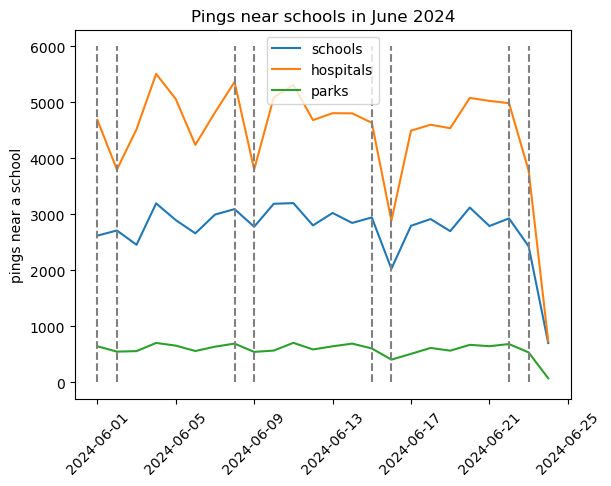

In [62]:
plt.plot(school_counts_day, label = 'schools')
plt.plot(hospital_counts_day, label = 'hospitals')
plt.plot(park_counts_day, label = 'parks')
for sun in sundays:
    plt.plot([sun, sun], [0, 6000], linestyle = '--', color = 'grey')
for sat in saturdays:
    plt.plot([sat, sat], [0, 6000], linestyle = '--', color = 'grey')
plt.xticks(rotation = 45)
plt.ylabel('pings near a school')
plt.title('Pings near schools in June 2024')
plt.legend();

In [70]:
school_counts_day = school_counts_day.reset_index()
hospital_counts_day = hospital_counts_day.reset_index()
park_counts_day = park_counts_day.reset_index()

In [71]:
school_correction = school_counts_day[~((school_counts_day['local_date'].isin(sundays)) | 
                                     (school_counts_day['local_date'].isin(saturdays)) |
                                     (school_counts_day['local_date'].isin(final_date)))]
school_correction.set_index('local_date', inplace = True)

hosp_correction = hospital_counts_day[~(hospital_counts_day['local_date'].isin(final_date))]
hosp_correction.set_index('local_date', inplace = True)

park_correction = park_counts_day[~(park_counts_day['local_date'].isin(final_date))]
park_correction.set_index('local_date', inplace = True)

In [73]:
temperature = pd.read_csv('daily_termperature_thermalcomfort_pasig_2015_2024.csv')
temperature['Date'] = pd.to_datetime(temperature['Date'])
temperature.set_index('Date', inplace = True)

In [83]:
corr_school = round(temperature.reindex(school_correction.index)['MaxTemp_daily'].corr(school_correction['counts']), 2)
corr_hosp = round(temperature.reindex(hosp_correction.index)['MaxTemp_daily'].corr(hosp_correction['counts']), 2)
corr_park = round(temperature.reindex(park_correction.index)['MaxTemp_daily'].corr(park_correction['counts']), 2)

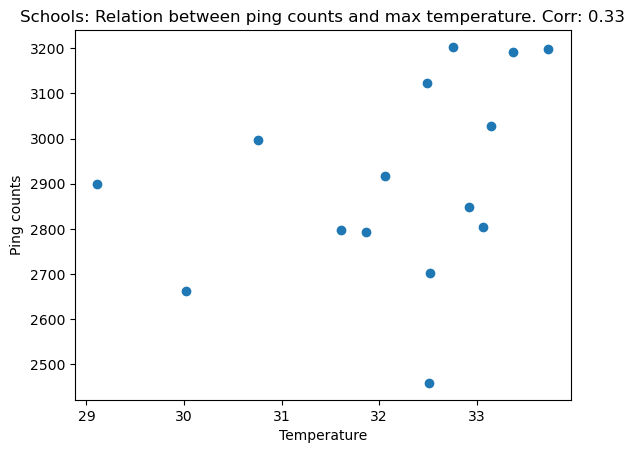

In [84]:
plt.scatter(temperature.reindex(school_correction.index)['MaxTemp_daily'], school_correction['counts'])
plt.title(f'Schools: Relation between ping counts and max temperature. Corr: {corr_school}')
plt.ylabel('Ping counts')
plt.xlabel('Temperature');

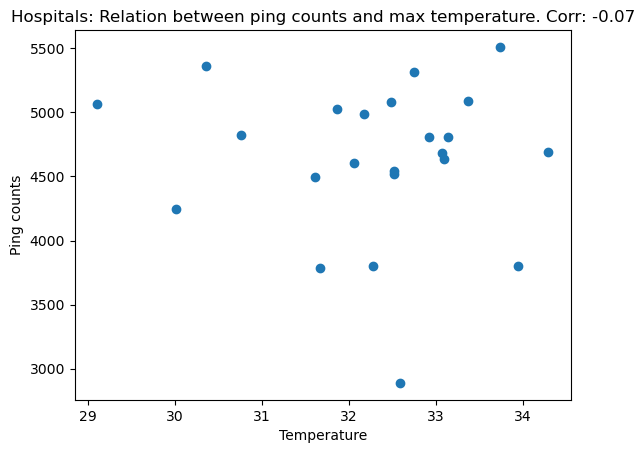

In [85]:
plt.scatter(temperature.reindex(hosp_correction.index)['MaxTemp_daily'], hosp_correction['counts'])
plt.title(f'Hospitals: Relation between ping counts and max temperature. Corr: {corr_hosp}')
plt.ylabel('Ping counts')
plt.xlabel('Temperature');

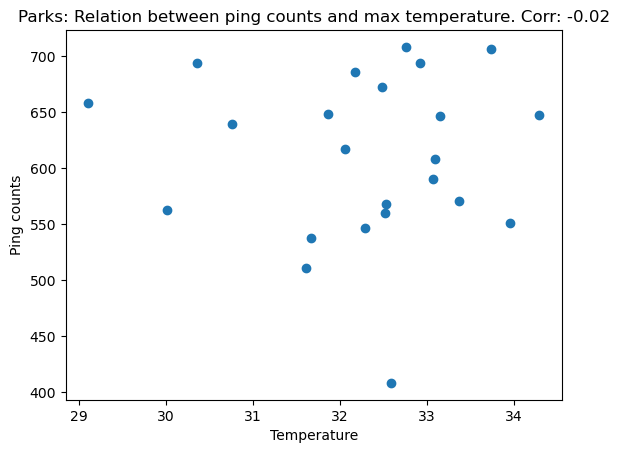

In [86]:
plt.scatter(temperature.reindex(park_correction.index)['MaxTemp_daily'], park_correction['counts'])
plt.title(f'Parks: Relation between ping counts and max temperature. Corr: {corr_park}')
plt.ylabel('Ping counts')
plt.xlabel('Temperature');